In [125]:
# import numpy matplotlib and qutip features
import numpy as np
import matplotlib.pyplot as plt
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz,
                   tensor)

# define Pauli matrices
σ_x = sigmax()
σ_y = sigmay()
σ_z = sigmaz()
I2 = qeye(2)

# XXZ Model with N = 2

In [110]:
# specify number of sites 
N = 10
Jxy = -1
Jz = -1

# initial state; one particle in |1> and the other N-1 particles in |0>
# the tensor product of this list of quantum objects works exactly 
# how you expect it would 
state_list = [basis(2, 1)] + [basis(2, 0)] * (N - 1)
ψ_0 = tensor(state_list)

# Interaction coefficients, which we assume are uniform throughout the lattice
Jxy_list = Jxy*np.ones(N)
Jz_list = Jz*np.ones(N)

$$ \Large  H = - J_{xy}\sum_{j=1}^{N-1} \left( X_j X_{j+1} + Y_j Y_{j+1} \right) - J_{z}\sum_{j=1}^{N-1} Z_j Z_{j+1} $$

In [111]:
# Setup operators for individual qubits; 
# here sx_list[j] = X_j, sy_list[j] = Y_j, and sz_list[j] = Z_j
# since the Pauli matrix occupies the jth location in the tensor product of many identities 
sx_list, sy_list, sz_list = [], [], []

for i in range(N):
    op_list = [qeye(2)] * N
    op_list[i] = sigmax()
    sx_list.append(tensor(op_list))
    op_list[i] = sigmay()
    sy_list.append(tensor(op_list))
    op_list[i] = sigmaz()
    sz_list.append(tensor(op_list))

# Hamiltonian - Energy splitting terms
H = 0

# Hamiltonians for XX, YY and ZZ interaction terms
for j in range(N - 1):
    H += -Jxy_list[j] * sx_list[j] * sx_list[j + 1]
    H += -Jxy_list[j] * sy_list[j] * sy_list[j + 1]
    H += -Jz_list[j] * sz_list[j] * sz_list[j + 1]

In [5]:
# mesolve returns the states at each given time step as it evolves
# according to the unitary evolution of the Hamiltonian
times = np.linspace(0, 100, 200)
result = mesolve(H, ψ_0, times, [], [])

# Convert states to density matrices
states = [s * s.dag() for s in result.states]

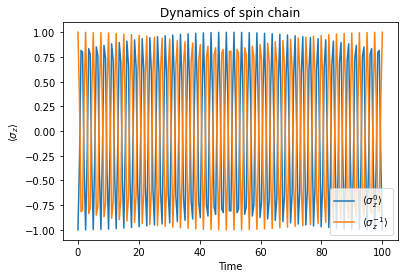

In [6]:
# takes the expectation of σ_z operator on each site as the spin chain evolves in time; exp_sz.shape = (199, N);
# expect(states, operators) => 199 tuples with length of tuple corresponding to number of sites 
# exp_sz(operators, states) => array of length N where each entry corresponds to a site's evolution over 199 time steps
exp_sz = np.array(expect(sz_list, states))

# Plot the expecation value of first qubit and last qubit 
plt.plot(times, exp_sz[0], label=r"$\langle \sigma_z^{0} \rangle$")
plt.plot(times, exp_sz[-1], label=r"$\langle \sigma_z^{-1} \rangle$")
plt.legend(loc="lower right")
plt.xlabel("Time")
plt.ylabel(r"$\langle \sigma_z \rangle$")
plt.title("Dynamics of spin chain");

We now introduce dephasing of each qubit $$ \Large C = \sum_{j=1}^{N} \sqrt{\gamma_j} Z_j $$

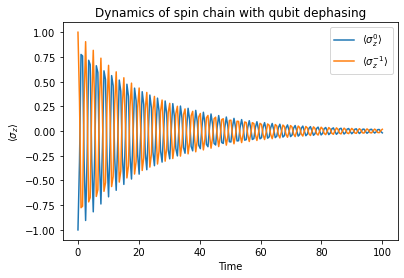

In [9]:
# dephasing rate
γ = 0.02 * np.ones(N)

# collapse operators
c_ops = [np.sqrt(γ[i]) * sz_list[i] for i in range(N)] 

# evolution
result = mesolve(H, ψ_0, times, c_ops, []) 

# Expectation value; qutip.expect(operators, state)
exp_sz_dephase = expect(sz_list, result.states)

# Plot the expecation value
plt.plot(times, exp_sz_dephase[0], label=r"$\langle \sigma_z^{0} \rangle$")
plt.plot(times, exp_sz_dephase[-1], label=r"$\langle \sigma_z^{-1} \rangle$")
plt.legend()
plt.xlabel("Time"), plt.ylabel(r"$\langle \sigma_z \rangle$")
plt.title("Dynamics of spin chain with qubit dephasing");

# Extra Code

In [144]:
def find_ground_state(N, Jx, Jy, Jz): 
    
    # Interaction coefficients, which we assume are uniform throughout the lattice
    Jx_list = Jx*np.ones(N)
    Jy_list = Jy*np.ones(N)
    Jz_list = Jz*np.ones(N)
    
    # Setup operators for individual qubits; 
    # here sx_list[j] = X_j, sy_list[j] = Y_j, and sz_list[j] = Z_j
    # since the Pauli matrix occupies the jth location in the tensor product of N terms
    # of which N-1 terms are the identity
    sx_list, sy_list, sz_list = [], [], []

    for i in range(N):
        op_list = [qeye(2)]*N
        op_list[i] = σ_x
        sx_list.append(tensor(op_list))
        op_list[i] = σ_y
        sy_list.append(tensor(op_list))
        op_list[i] = σ_z
        sz_list.append(tensor(op_list))

    # generate Hamiltonian by computing XX, YY and ZZ interactions in Hamiltonian
    H = 0 
    for j in range(N - 1):
        H += Jx_list[j] * sx_list[j] * sx_list[j + 1]
        H += Jy_list[j] * sy_list[j] * sy_list[j + 1]
        H += Jz_list[j] * sz_list[j] * sz_list[j + 1]
    
    # find eigenavlues and eigenstates of Hamiltonian 
    eigenvalues, eigenstates = H.eigenstates()

    # find indices of smallest eigenvalues, which correspond to the energy(ies) 
    # of the ground state (space in the case of degeneracy); 
    min_value = min(eigenvalues)
    indices = [index for index, value in enumerate(eigenvalues) if value == min_value]

    # find eigenstates corresponding to ground state
    eigenstates_list = eigenstates[indices]

    # create superposition of all eigenstates in the ground state space
    # note that if the ground state is not degenerate, then this just return the 
    # eigenstate corresponding to the lowest eigenvalue
    ground_state = 0 
    for j in range(len(eigenstates_list)):
        ground_state += eigenstates_list[j]
    
    # return normalized ground state
    return ground_state.unit()

In [149]:
N = 5
Jx = 1
Jy = 1
Jz = 1
find_ground_state(N, Jx, Jy, Jz)

Quantum object: dims = [[2, 2, 2, 2, 2], [1, 1, 1, 1, 1]], shape = (32, 1), type = ket
Qobj data =
[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-4.64060131e-05]
 [ 0.00000000e+00]
 [ 2.25337043e-04]
 [-2.25337043e-04]
 [-4.79885849e-02]
 [ 0.00000000e+00]
 [-3.71768275e-04]
 [ 6.43511331e-04]
 [ 2.33021651e-01]
 [-2.25337043e-04]
 [-3.84446589e-01]
 [ 1.99413522e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.92837246e-04]
 [-3.71768275e-04]
 [-2.33021651e-01]
 [ 2.25337043e-04]
 [ 6.65456824e-01]
 [-3.84446589e-01]
 [ 0.00000000e+00]
 [-4.64060131e-05]
 [-2.33021651e-01]
 [ 2.33021651e-01]
 [ 0.00000000e+00]
 [-4.79885849e-02]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]